In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import collections
from sklearn.decomposition import PCA

In [43]:
# nltkのダウンロード
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("reuters")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/morikazuhito/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/morikazuhito/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     /Users/morikazuhito/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/morikazuhito/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [44]:
# arxivからデータの取得

import arxiv
import pandas as pd

search_MA = arxiv.Search(query='cat:cs.MA',max_results=100,sort_by=arxiv.SortCriterion.SubmittedDate,sort_order=arxiv.SortOrder.Descending)
search_EM = arxiv.Search(query='cat:econ.EM',max_results=100,sort_by=arxiv.SortCriterion.SubmittedDate,sort_order=arxiv.SortOrder.Descending)
search_AG = arxiv.Search(query='cat:math.AG',max_results=100,sort_by=arxiv.SortCriterion.SubmittedDate,sort_order=arxiv.SortOrder.Descending)
search_CB = arxiv.Search(query='cat:q-bio.CB',max_results=100,sort_by=arxiv.SortCriterion.SubmittedDate,sort_order=arxiv.SortOrder.Descending)
search_ML = arxiv.Search(query='cat:stat.ML',max_results=100,sort_by=arxiv.SortCriterion.SubmittedDate,sort_order=arxiv.SortOrder.Descending)
search_list = [search_MA,search_EM,search_AG,search_CB,search_ML]

sum_list = []
ti_list = []
cat_list = []

for i ,search in enumerate(search_list):
    for result in search.results():
        sum_list.append(result.summary)
        ti_list.append(result.title)
        cat_list.append(i)



In [45]:
# データ例
print(ti_list[0])
print(sum_list[0])

Channel Cycle Time: A New Measure of Short-term Fairness
This paper puts forth a new metric, dubbed channel cycle time, to measure the
short-term fairness of communication networks. Channel cycle time characterizes
the average duration between two successful transmissions of a user, during
which all other users have successfully accessed the channel at least once.
Compared with existing short-term fairness measures, channel cycle time
provides a comprehensive picture of the transient behavior of communication
networks, and is a single real value that is easy to compute. To demonstrate
the effectiveness of our new approach, we analytically characterize the channel
cycle time of slotted Aloha and CSMA/CA. It is shown that CSMA/CA is a
short-term fairer protocol than slotted Aloha. Channel cycle time can serve as
a promising design principle for future communication networks, placing greater
emphasis on optimizing short-term behaviors like fairness, delay, and jitter.


In [46]:
# 単語列のリストに分割
docs = [summary.split() for summary in sum_list]
print(type(docs))
print(docs[:5])
print("num of docs:", len(docs))

<class 'list'>
[['This', 'paper', 'puts', 'forth', 'a', 'new', 'metric,', 'dubbed', 'channel', 'cycle', 'time,', 'to', 'measure', 'the', 'short-term', 'fairness', 'of', 'communication', 'networks.', 'Channel', 'cycle', 'time', 'characterizes', 'the', 'average', 'duration', 'between', 'two', 'successful', 'transmissions', 'of', 'a', 'user,', 'during', 'which', 'all', 'other', 'users', 'have', 'successfully', 'accessed', 'the', 'channel', 'at', 'least', 'once.', 'Compared', 'with', 'existing', 'short-term', 'fairness', 'measures,', 'channel', 'cycle', 'time', 'provides', 'a', 'comprehensive', 'picture', 'of', 'the', 'transient', 'behavior', 'of', 'communication', 'networks,', 'and', 'is', 'a', 'single', 'real', 'value', 'that', 'is', 'easy', 'to', 'compute.', 'To', 'demonstrate', 'the', 'effectiveness', 'of', 'our', 'new', 'approach,', 'we', 'analytically', 'characterize', 'the', 'channel', 'cycle', 'time', 'of', 'slotted', 'Aloha', 'and', 'CSMA/CA.', 'It', 'is', 'shown', 'that', 'CSMA/C

#### 前処理関数の作成

In [98]:
en_stop = nltk.corpus.stopwords.words('english')
en_stop += ["propose","model","data","method","result","show","use","using"]

In [99]:
from nltk.corpus import wordnet as wn #lemmatize関数のためのimport

def preprocess_word(word, stopwordset):
    
    #1.make words lower ex: Python =>python
    word=word.lower()
    
    #2.remove "," and "."
    if word in [",","."]:
        return None
    
    #3.remove stopword  ex: the => (None) 
    if word in stopwordset:
        return None
    
    #4.lemmatize  ex: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word

    elif lemma in stopwordset: #lemmatizeしたものがstopwordである可能性がある
        return None
    else:
        return lemma
    

def preprocess_document(document):
    document=[preprocess_word(w, en_stop) for w in document]
    document=[w for w in document if w is not None]
    return document

def preprocess_documents(documents):
    return [preprocess_document(document) for document in documents]

前処理

In [100]:
print(docs[0][:25]) 

['This', 'paper', 'puts', 'forth', 'a', 'new', 'metric,', 'dubbed', 'channel', 'cycle', 'time,', 'to', 'measure', 'the', 'short-term', 'fairness', 'of', 'communication', 'networks.', 'Channel', 'cycle', 'time', 'characterizes', 'the', 'average']


In [101]:
print(preprocess_documents(docs)[0][:25])

['paper', 'put', 'forth', 'new', 'metric,', 'dub', 'channel', 'cycle', 'time,', 'measure', 'short-term', 'fairness', 'communication', 'networks.', 'channel', 'cycle', 'time', 'characterize', 'average', 'duration', 'two', 'successful', 'transmission', 'user,', 'user']


In [102]:
# 前処理後のカテゴリごとの単語の出現頻度をカウント
category_words = {}
num_categories = max(cat_list) + 1
for category in range(num_categories):
    category_words[category] = collections.Counter()

for i, doc in enumerate(preprocess_documents(docs)):
    category = cat_list[i]
    for word in doc:
        category_words[category][word] += 1

# カテゴリごとに出現頻度の高い単語をランキング
category_rankings = {}
for category, word_counts in category_words.items():
    category_rankings[category] = word_counts.most_common()

# 結果の表示
for category, rankings in category_rankings.items():
    print(f'Category {category}:')
    for i, (word, count) in enumerate(rankings):
        if i > 5:
            break
        print(f'{word}: {count}')
    print()

Category 0:
agent: 159
learning: 90
multi-agent: 76
algorithm: 72
problem: 62
policy: 57

Category 1:
estimator: 73
estimate: 72
estimation: 52
paper: 45
factor: 45
study: 43

Category 2:
prove: 64
space: 45
group: 44
variety: 39
surface: 37
modulus: 34

Category 3:
cell: 335
system: 73
pattern: 47
study: 42
cellular: 41
tissue: 37

Category 4:
learning: 65
algorithm: 65
network: 50
problem: 45
study: 41
exist: 39



tf idf によるクラスタリング

In [103]:
pre_docs=preprocess_documents(docs)
pre_docs=[" ".join(doc) for doc in pre_docs]
print(pre_docs[0])

vectorizer = TfidfVectorizer(max_features=200, token_pattern=u'(?u)\\b\\w+\\b' )

paper put forth new metric, dub channel cycle time, measure short-term fairness communication networks. channel cycle time characterize average duration two successful transmission user, user successfully access channel least once. compare exist short-term fairness measures, channel cycle time provide comprehensive picture transient behavior communication networks, single real value easy compute. demonstrate effectiveness new approach, analytically characterize channel cycle time slot aloha csma/ca. csma/ca short-term fair protocol slot aloha. channel cycle time serve promise design principle future communication networks, place greater emphasis optimize short-term behavior like fairness, delay, jitter.


In [104]:
tf_idf = vectorizer.fit_transform(pre_docs)

In [105]:
# 主成分分析により2次元に削減
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(tf_idf.toarray())

#### K-means

In [106]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state = 0)

In [107]:
clusters = km.fit_predict(tf_idf)

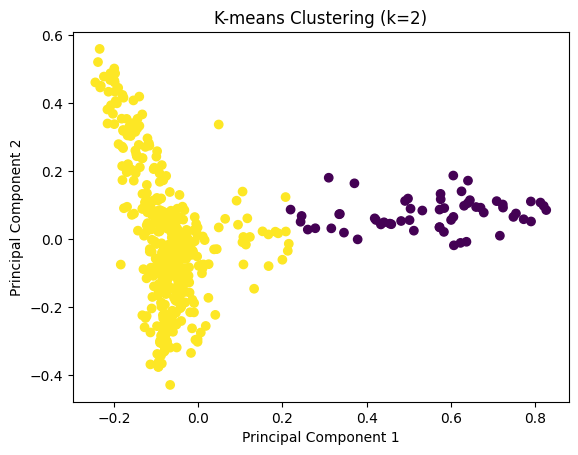

In [108]:
# 可視化
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering (k={})'.format(str(num_clusters)))
plt.show()

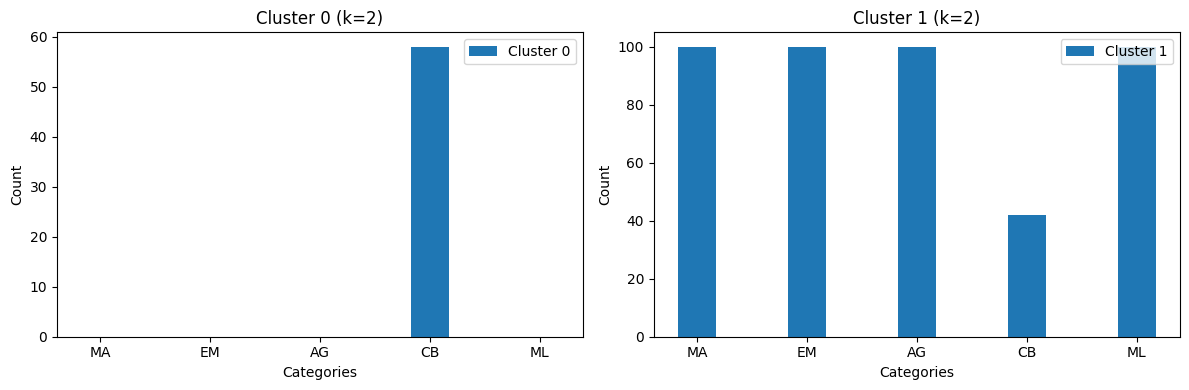

In [109]:
import numpy as np
import matplotlib.pyplot as plt

# クラスタごとのカテゴリの出現数
category_counts = np.zeros((num_clusters, max(cat_list) + 1))
for cluster, category in zip(clusters, cat_list):
    category_counts[cluster][category] += 1

# 可視化
x = np.arange(max(cat_list) + 1)
width = 0.35
category_labels = {
    0: 'MA',
    1: 'EM',
    2: 'AG',
    3: 'CB',
    4: 'ML'
}

# サブプロットの設定
fig, axes = plt.subplots(1, num_clusters, figsize=(12, 4))

# 各クラスタのグラフを作成
for cluster in range(num_clusters):
    axes[cluster].bar(x, category_counts[cluster], width, label=f'Cluster {cluster}')
    axes[cluster].set_xlabel('Categories')
    axes[cluster].set_ylabel('Count')
    axes[cluster].set_title(f'Cluster {cluster} (k={num_clusters})')
    axes[cluster].set_xticks(x)
    axes[cluster].set_xticklabels([category_labels[i] for i in range(len(category_labels))])
    axes[cluster].legend()

# グラフの間隔を調整
plt.tight_layout()

# グラフを表示
plt.show()

In [110]:
import csv

csv_file = "output.csv"
rows = zip(clusters,cat_list,ti_list,sum_list)

# CSVファイルに書き込み
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['K-means_label', 'category', 'title','abstract'])  # 列のヘッダーを書き込み
    writer.writerows(rows)  # 行のデータを書き込み